In [1]:
import numpy as np
from neuralop.models import FNO
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle as pk
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from utils.visualizations import *
import torch

In [2]:
train_data_loc = '/home/arunreddy/ML/Social-Robots/Human_Motion_Refine (1)/data/data_more_processing/normalized_axis_magnitude_train_data_new.npy'
train_data = np.load(train_data_loc, allow_pickle=True)

In [3]:
type(train_data), train_data.shape

(numpy.ndarray, (994, 2, 300, 242))

##### The main thing, here is to first verify if the corresponding pairs actually represent the dataset properly
##### Plot and visualize both the source and target pairs for multiple data-points as a sanity check.

In [34]:
datapoint = 99

In [35]:
source = train_data[datapoint][0]
target = train_data[datapoint][1]

In [36]:
source.shape, target.shape

((300, 242), (300, 242))

In [37]:
source_torch = torch.tensor(source).unsqueeze(0).permute(0, 2, 1).float()
target_torch = torch.tensor(target).unsqueeze(0).permute(0, 2, 1).float()

In [38]:
# input to the neural operator is of the form, (N, C, T)

In [39]:
fno_model = FNO(n_modes=(150,), hidden_channels=500, in_channels=242, out_channels=242).float()

In [40]:
output_torch = fno_model(source_torch)

In [41]:
output_torch.shape

torch.Size([1, 242, 300])

In [42]:
F.mse_loss(output_torch, target_torch)

tensor(0.0304, grad_fn=<MseLossBackward0>)

##### Basic Training Run

In [43]:
loss_vals = []

##### Model requires really large lr for convergence. lr = 1, is Unusual

In [44]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.SGD(fno_model.parameters(), lr=1)  # Stochastic Gradient Descent
num_epochs = 100

In [45]:
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output_torch = fno_model(source_torch)
    loss = criterion(output_torch, target_torch)
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
    if epoch % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  1%|          | 1/100 [00:01<02:52,  1.74s/it]

Epoch 0, Loss: 0.030443469062447548


 11%|█         | 11/100 [00:18<02:29,  1.68s/it]

Epoch 10, Loss: 0.024237290024757385


 21%|██        | 21/100 [00:36<02:16,  1.72s/it]

Epoch 20, Loss: 0.019263751804828644


 31%|███       | 31/100 [00:52<01:54,  1.66s/it]

Epoch 30, Loss: 0.015197549015283585


 41%|████      | 41/100 [01:09<01:37,  1.66s/it]

Epoch 40, Loss: 0.011875055730342865


 51%|█████     | 51/100 [01:25<01:23,  1.71s/it]

Epoch 50, Loss: 0.009211849421262741


 61%|██████    | 61/100 [01:43<01:05,  1.68s/it]

Epoch 60, Loss: 0.007154295686632395


 71%|███████   | 71/100 [02:00<00:47,  1.65s/it]

Epoch 70, Loss: 0.005645629484206438


 81%|████████  | 81/100 [02:17<00:32,  1.69s/it]

Epoch 80, Loss: 0.0046072835102677345


 91%|█████████ | 91/100 [02:34<00:15,  1.76s/it]

Epoch 90, Loss: 0.003939534537494183


100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


In [46]:
loss_vals[0]

0.030443469062447548

In [47]:
loss_vals[-1]

0.0035683244932442904

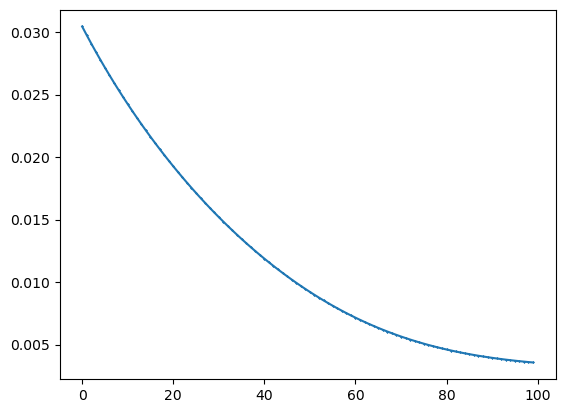

In [48]:
plt.plot(loss_vals, marker = 'x', markersize=1, markerfacecolor = 'r')

In [49]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [50]:
count_parameters(fno_model)

79494742

In [51]:
242*300

72600

In [77]:
(np.sqrt(loss_vals[0])/(abs(target_torch).mean()))*100

tensor(124.7335)

In [78]:
(np.sqrt(loss_vals[-1])/(abs(target_torch).mean()))*100

tensor(42.7040)

In [56]:
source_torch.shape, target_torch.shape, output_torch.shape

(torch.Size([1, 242, 300]),
 torch.Size([1, 242, 300]),
 torch.Size([1, 242, 300]))

##### Experiment with more optimizers and newer learning rates. Figure out why you needed a larger learning rate

##### Reverse Process

In [62]:
def denormalize_global(array, min_val=-5.049882127052023, max_val=6.446737822522641):
    if max_val == min_val:
        return np.zeros_like(array)
    return (array + 1) * (max_val - min_val) / 2 + min_val

In [63]:
def convert_to_axis_angle(data):
    '''data [T, 242]'''
    axis_magnitude = data[:, 6:226].reshape(-1, 55, 4)
    axis = axis_magnitude[:, :, :3]
    magnitude = axis_magnitude[:, :, 3:]
    poses = axis * (magnitude+1e-10)
    poses = poses.reshape(axis_magnitude.shape[0], -1)
    new_data = torch.cat([data[:, :6], poses, data[:, 226:]], axis=1)
    return new_data

In [69]:
source_un_norm = denormalize_global(source_torch.permute(0, 2, 1))
source_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in source_un_norm])

In [72]:
target_un_norm = denormalize_global(target_torch.permute(0, 2, 1))
target_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in target_un_norm])

In [73]:
output_un_norm = denormalize_global(output_torch.permute(0, 2, 1))
output_un_norm_axis_angle = torch.stack([convert_to_axis_angle(point) for point in output_un_norm])

In [74]:
source_un_norm_axis_angle.shape, target_un_norm_axis_angle.shape, output_un_norm_axis_angle.shape

(torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]),
 torch.Size([1, 300, 187]))

In [ ]:
path = '/home/arunreddy/ML/Social-Robots/Code/Duolando-main/animations_test'

In [75]:
vis_results(source_un_norm_axis_angle, target_un_norm_axis_angle, output_un_norm_axis_angle, 100, path, is_smplx=True)

np.float64(0.05973545423987576)